# Time Series

- https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [4]:
!pip install tbats

In [1]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle
from tbats import TBATS, BATS

In [2]:
# definir parâmetros extras
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
# definir parâmetros extras
pd.set_option('precision', 4)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
input_prefix = 'data/'
#input_prefix = 'https://github.com/hjort/ai-labs/raw/master/jupyter/sales-russia/data/'

bzfile = '.bz2' # ''

In [5]:
df_train = pd.read_csv(
    input_prefix + '../sales_monthly.csv' + bzfile, #nrows=10000,
    #input_prefix + '../sales_monthly_full.csv' + bzfile, #nrows=10000,
    #input_prefix + '../train_full.csv' + bzfile, #nrows=10000,
    dtype={'date_block_num': np.int8, 'shop_id': np.int8, 'item_id': np.int16,
           'item_price_mean': np.int32, 'item_cnt_sum': np.int32,
           'city_code': 'category', 'item_category_id': 'category',
           'subject_code': 'category', 'group_code': 'category', 'subgroup_code': 'category'},
    index_col=['shop_id', 'item_id', 'date_block_num']
)
print('shape:', df_train.shape)
df_train.head()

shape: (1608226, 2)


/dados/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [6]:
data = df_train.copy()
#data = df_train.drop(columns=['city_code', 'item_category_id', 'subject_code', 'group_code', 'subgroup_code'])

In [7]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [8]:
data = data.query('(shop_id == 5) & (item_id == 5037)')
#data = data.query('(shop_id == 28) & (item_id == 20949)')
#data = data.query('(shop_id == 31) & (item_id == 20949)')
#data = data.query('(shop_id == 55) & (item_id == 492)')

In [9]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
5       5037    20                         2599             1
                22                         2599             1
                23                         1999             2
                24                         1999             2
                28                         1299             1

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9 entries, (5, 5037, 20) to (5, 5037, 32)
Data columns (total 2 columns):
item_price_mean    9 non-null int32
item_cnt_sum       9 non-null int32
dtypes: int32(2)
memory usage: 171.4 KB


In [11]:
data = data.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1


In [12]:
data = pd.merge(pd.DataFrame({'date_block_num': np.arange(data.index.min(), 34)}).set_index('date_block_num'),
         data, how='left', left_index=True, right_index=True)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599.0,1.0
21,NaN,NaN
22,2599.0,1.0
23,1999.0,2.0
24,1999.0,2.0


In [13]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499.0,1.0
30,1499.0,1.0
31,1000.0,3.0
32,750.0,1.0
33,NaN,NaN


In [14]:
data['item_cnt_sum'] = data['item_cnt_sum'].fillna(0).astype(np.int32)
data['item_price_mean'] = data['item_price_mean'].fillna(method='bfill').fillna(method='ffill').astype(np.int32)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
21,2599,0
22,2599,1
23,1999,2
24,1999,2


In [15]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499,1
30,1499,1
31,1000,3
32,750,1
33,750,0


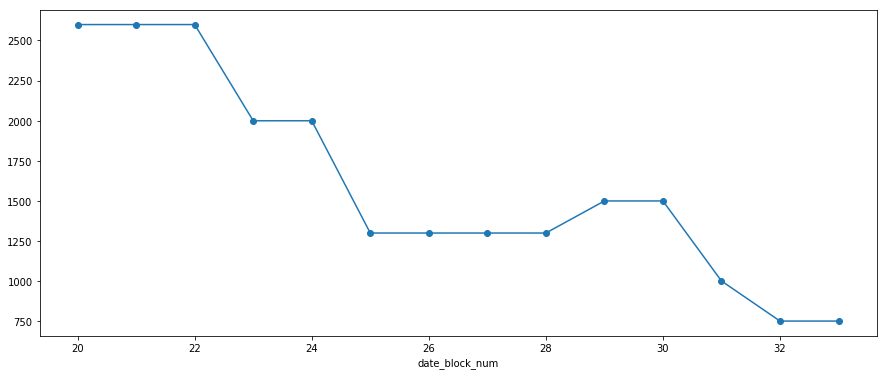

In [16]:
data['item_price_mean'].plot(marker='o')

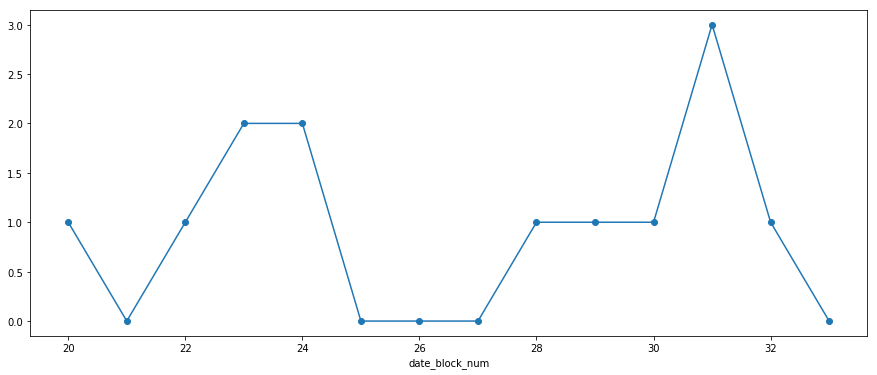

In [17]:
data['item_cnt_sum'].plot(marker='o')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27db056358>,
      dtype=object)

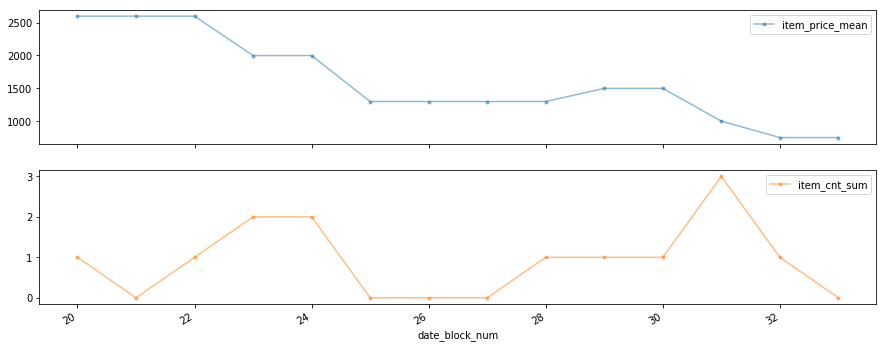

In [18]:
data.plot(marker='.', alpha=0.5, subplots=True)

# definir períodos a serem considerados no modelo
periodo1 = 1.0
periodo2 = 365.25

# definir data inicial de corte
data_inicio_amostra = '2014-11'

print('Períodos sazonais: (%.2f, %.2f)' % (periodo1, periodo2))
print('Data de início da amostra:', data_inicio_amostra)

In [19]:
y = data['item_cnt_sum']

tamanho = len(y)
corte = int(np.ceil(tamanho * 0.75))
resto = tamanho - corte
print('Tamanho: %-3d\nCorte:   %-3d\nResto:    %-3d' % (tamanho, corte, resto))

y_train = y.iloc[:corte]
y_test = y.iloc[corte:]

Tamanho: 14 
Corte:   11 
Resto:    3  


In [20]:
y_train[:5]

date_block_num
20    1
21    0
22    1
23    2
24    2
Name: item_cnt_sum, dtype: int32

In [21]:
y_test[-5:]

date_block_num
31    3
32    1
33    0
Name: item_cnt_sum, dtype: int32

In [22]:
# Fit the model
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)
%time model = estimator.fit(y_train)

CPU times: user 375 ms, sys: 75.6 ms, total: 451 ms
Wall time: 2.66 s


In [23]:
# Forecast 365 days ahead
y_forecast = model.forecast(steps=resto)
print(y_forecast)

y_forecast = y_forecast.round().astype(np.int32)
y_forecast

[ 3.00000000e+00  1.00000000e+00 -5.55111512e-16]


array([3, 1, 0], dtype=int32)

In [25]:
y_true = y[-resto:].values
y_true

array([3, 1, 0], dtype=int32)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('MSE:', mean_squared_error(y_true, y_forecast))
print('MAE:', mean_absolute_error(y_true, y_forecast))
print('R²:', r2_score(y_true, y_forecast))

MSE: 0.0
MAE: 0.0
R²: 1.0


In [27]:
%time model = estimator.fit(y)

CPU times: user 442 ms, sys: 84 ms, total: 526 ms
Wall time: 2.44 s


In [28]:
y_pred = model.forecast(steps=3)
y_pred = y_pred.round().clip(0, 20).astype(np.int32)
y_pred

array([1, 2, 2], dtype=int32)

In [29]:
df_test = pd.read_csv(
    input_prefix + 'test.csv' + bzfile, #nrows=10000,
    dtype={'shop_id': np.int8, 'item_id': np.int16},
    index_col='ID')
print('shape:', df_test.shape)
df_test.head()

shape: (214200, 2)


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [36]:
#!rm -f prediction.csv && touch prediction.csv

In [30]:
filename = 'prediction.csv'
last_id = None

with open(filename) as infile:
  empty = (infile.read(1) == '')
  if (not empty):
    last_line = list(infile)[-1]
    last_id = int(last_line.split(',')[0])
infile.close()

outfile = open(filename, "a+", buffering=100)
if (empty):
  outfile.write('ID,item_cnt_month\n')
  print('File does not exist. Creating one.')
else:
  print('File already exists. Resuming from ID #%d' % last_id)

#for i in range(0, 10):
#  outfile.write("%d,%.1f\n" % (i, i%7))
#outfile.close()

File already exists. Resuming from ID #39900


In [31]:
!tail prediction.csv

39891,0.0
39892,0.0
39893,0.0
39894,0.0
39895,0.0
39896,0.0
39897,0.0
39898,0.0
39899,0.0
39900,0.0


In [ ]:
estimator = TBATS(seasonal_periods=(12,), n_jobs=8)

for index, row in df_test.iterrows():
#for index, row in df_test.head(10).iterrows():
    if (last_id and index <= last_id):
      continue

    shop_id = row['shop_id']
    item_id = row['item_id']
    #print(index, shop_id, item_id)

    #df_sale = df_train.loc[shop_id, item_id][['item_cnt_sum']]
    df_sale = df_train.query('(shop_id == %d) & (item_id == %d)' % (shop_id, item_id))[['item_cnt_sum']]
    if (not df_sale.empty):

      df_sale = df_sale.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
      df_sale = pd.merge(
        pd.DataFrame({'date_block_num': np.arange(df_sale.index.min(), 34)}).set_index('date_block_num'),
        df_sale, how='left', left_index=True, right_index=True)
      df_sale['item_cnt_sum'] = df_sale['item_cnt_sum'].fillna(0).astype(np.int32)
      #df_sale['item_price_mean'] = df_sale['item_price_mean'].fillna(
      #  method='bfill').fillna(method='ffill').astype(np.int32)

      if (df_sale.shape[0] >= 4):
          model = estimator.fit(df_sale['item_cnt_sum'])
          y_pred = model.forecast(steps=1)
          y_pred = y_pred[0].round().clip(0, 20)
          #y_pred = y_pred[0].round().clip(0, 20).astype(np.int32)
      else:
          y_pred = 0
    else:
      y_pred = 0
    
    outfile.write("%d,%.1f\n" % (index, y_pred))

    if (index % 10 == 0):
      outfile.flush()
      print(index, shop_id, item_id, y_pred)

outfile.close()

39910 12 18031 0
39920 12 20821 0
39930 12 18939 0
39940 12 12208 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


39950 12 15654 0
39960 12 16028 0
39970 12 20516 0.0
39980 12 6400 0
39990 12 16166 0
40000 12 9534 0
40010 12 10581 0
40020 12 9111 0
40030 12 13099 0
40040 12 11874 0
40050 12 12192 0
40060 12 6430 0
40070 12 5761 0
40080 12 4903 0
40090 12 5382 0
40100 12 7817 0
40110 12 6959 0
40120 12 7057 0
40130 12 21978 0
40140 12 19347 0
40150 12 20012 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40160 12 13732 0
40170 12 14934 0
40180 12 13341 0
40190 12 16396 0
40200 12 16813 0
40210 12 15988 0
40220 12 16272 0
40230 12 504 0
40240 12 688 0
40250 12 616 0
40260 12 204 0
40270 12 1394 0
40280 12 924 0
40290 12 1506 0
40300 12 849 0
40310 12 20361 0.0
40320 12 3715 0
40330 12 3411 0
40340 12 4765 0
40350 12 4260 0
40360 12 4144 0
40370 12 4203 0
40380 12 1794 0
40390 12 2338 0
40400 12 1792 0
40410 12 2856 0
40420 12 2434 0
40430 12 3136 0
40440 12 1018 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40450 12 19258 0.0
40460 12 4736 0.0
40470 12 5363 0
40480 12 17390 0
40490 12 11682 0
40500 12 15735 0
40510 12 14899 1.0
40520 12 20212 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40530 12 5899 0.0
40540 12 18476 0
40550 12 6835 0.0
40560 12 15405 0
40570 12 17756 0.0
40580 12 18500 0
40590 12 16231 0
40600 12 17015 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40610 12 13133 0
40620 12 14222 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40630 12 13812 0
40640 12 5010 2.0
40650 12 21210 0
40660 12 20916 0
40670 12 21664 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40680 12 3232 0
40690 12 3547 0
40700 12 18707 0
40710 12 11674 0
40720 12 16057 0.0
40730 12 15033 0
40740 12 10508 0.0
40750 12 7572 0
40760 12 6882 0.0
40770 12 14543 0
40780 12 19889 0
40790 12 3280 1.0
40800 28 5037 2.0
40810 28 4806 6.0
40820 28 4717 2.0
40830 28 5666 3.0
40840 28 5840 0
40850 28 5838 0.0
40860 28 3352 0
40870 28 3604 0
40880 28 3443 9.0
40890 28 4365 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40900 28 3733 20.0
40910 28 4052 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40920 28 9395 3.0
40930 28 9469 0
40940 28 8653 2.0
40950 28 9001 0.0
40960 28 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40970 28 10327 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


40980 28 9927 0
40990 28 6506 0
41000 28 6731 0
41010 28 6396 2.0
41020 28 6064 8.0
41030 28 7862 0
41040 28 7328 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41050 28 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41060 28 15777 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41070 28 16843 16.0
41080 28 15496 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41090 28 16103 0.0
41100 28 18825 0.0
41110 28 19656 0
41120 28 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41130 28 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41140 28 13023 3.0
41150 28 13415 0
41160 28 13464 0.0
41170 28 14832 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41180 28 15069 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41190 28 15037 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41200 28 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41210 28 1732 0
41220 28 2574 1.0
41230 28 3076 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41240 28 2779 0.0
41250 28 2873 0.0
41260 28 20949 20.0
41270 28 21937 0
41280 28 20400 0
41290 28 20616 4.0
41300 28 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41310 28 982 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41320 28 1486 8.0
41330 28 2328 0
41340 28 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41350 28 3022 0
41360 28 2743 0.0
41370 28 1963 0
41380 28 1295 0.0
41390 28 22100 5.0
41400 28 482 2.0
41410 28 1877 3.0
41420 28 1570 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41430 28 4003 1.0
41440 28 3851 0.0
41450 28 4420 2.0
41460 28 4085 7.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41470 28 3528 1.0
41480 28 3459 0
41490 28 12771 0.0
41500 28 13334 0
41510 28 15047 18.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41520 28 13818 0
41530 28 12549 1.0
41540 28 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41550 28 12360 1.0
41560 28 11811 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41570 28 12023 0
41580 28 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41590 28 13303 0
41600 28 13226 0
41610 28 20609 0.0
41620 28 19430 3.0
41630 28 21942 0
41640 28 18201 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41650 28 16122 0.0
41660 28 14668 0.0
41670 28 15323 1.0
41680 28 17481 1.0
41690 28 16541 2.0
41700 28 1239 0.0
41710 28 20631 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41720 28 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41730 28 15282 0.0
41740 28 16145 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41750 28 19125 0
41760 28 17032 0
41770 28 5383 0
41780 28 4895 3.0
41790 28 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41800 28 6082 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41810 28 3822 0.0
41820 28 6129 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41830 28 3833 5.0
41840 28 3871 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41850 28 13285 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41860 28 11938 1.0
41870 28 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41880 28 7982 1.0
41890 28 7224 0
41900 28 10211 13.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41910 28 9404 3.0
41920 28 4049 2.0
41930 28 4999 3.0
41940 28 3342 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41950 28 10190 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


41960 28 9408 1.0
41970 28 13237 0
41980 28 10987 0.0
41990 28 6625 0.0
42000 28 6090 2.0
42010 28 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42020 28 12500 0.0
42030 28 10448 0
42040 28 12805 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42050 28 14247 1.0
42060 28 7133 0
42070 28 10292 3.0
42080 28 1007 1.0
42090 28 1717 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42100 28 14390 0.0
42110 28 19908 0.0
42120 28 17888 0
42130 28 21722 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42140 28 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42150 28 18926 0.0
42160 28 17772 0
42170 28 19219 0
42180 28 20225 0.0
42190 28 5816 1.0
42200 28 8868 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42210 28 17459 0.0
42220 28 17420 0.0
42230 28 10812 0
42240 28 11771 0
42250 28 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42260 28 10378 1.0
42270 28 16125 0.0
42280 28 15300 0.0
42290 28 17270 0.0
42300 28 16735 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42310 28 13893 0.0
42320 28 13633 0
42330 28 14267 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42340 28 7592 0
42350 28 8734 6.0
42360 28 8986 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42370 28 8453 0
42380 28 4141 0
42390 28 6420 1.0
42400 28 11266 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42410 28 13270 0.0
42420 28 13100 0.0
42430 28 10146 1.0
42440 28 10425 0
42450 28 11365 0
42460 28 14848 0.0
42470 28 21367 4.0
42480 28 8077 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42490 28 12286 0.0
42500 28 3028 3.0
42510 28 3862 0.0
42520 28 794 0
42530 28 353 0
42540 28 1074 0.0
42550 28 13208 0
42560 28 12501 0.0
42570 28 10045 0
42580 28 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42590 28 11534 3.0
42600 28 15512 0
42610 28 15166 0
42620 28 16534 0.0
42630 28 16155 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42640 28 12830 0.0
42650 28 14124 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42660 28 5945 1.0
42670 28 6678 0
42680 28 4944 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42690 28 5517 0
42700 28 8398 0
42710 28 7458 0.0
42720 28 7882 0.0
42730 28 7793 2.0
42740 28 3477 4.0
42750 28 8686 0.0
42760 28 20560 0
42770 28 19874 0
42780 28 17869 1.0
42790 28 21548 0
42800 28 18255 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42810 28 2639 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42820 28 21827 0.0
42830 28 1238 0.0
42840 28 1247 1.0
42850 28 269 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42860 28 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42870 28 93 1.0
42880 28 20718 0
42890 28 42 0.0
42900 28 21842 1.0
42910 28 2324 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42920 28 1663 0.0
42930 28 3080 0.0
42940 28 2886 1.0
42950 28 13587 0
42960 28 13691 0
42970 28 15169 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


42980 28 14973 0
42990 28 13113 2.0
43000 28 11711 1.0
43010 28 13231 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43020 28 18677 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43030 28 18686 1.0
43040 28 20374 1.0
43050 28 20571 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43060 28 19621 2.0
43070 28 16036 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43080 28 15276 1.0
43090 28 16177 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43100 28 8687 1.0
43110 28 9171 0.0
43120 28 9366 0
43130 28 7459 2.0
43140 28 8148 0
43150 28 8510 2.0
43160 28 9449 0.0
43170 28 10786 1.0
43180 28 10669 0.0
43190 28 11379 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43200 28 11542 0
43210 28 10893 0.0
43220 28 9539 0.0
43230 28 10325 0.0
43240 28 9840 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43250 28 10003 0.0
43260 28 4708 3.0
43270 28 4604 0.0
43280 28 5323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43290 28 3897 0.0
43300 28 3919 0
43310 28 3787 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43320 28 4088 0
43330 28 6695 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43340 28 6378 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43350 28 6857 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43360 28 5659 0.0
43370 28 3354 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43380 28 1538 9.0
43390 28 22111 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43400 28 9019 0.0
43410 28 11968 0.0
43420 28 6027 1.0
43430 28 18361 0.0
43440 28 18629 0
43450 28 17883 0.0
43460 28 18108 10.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43470 28 19126 0.0
43480 28 19488 0
43490 28 18759 0
43500 28 18979 0
43510 28 3236 0.0
43520 28 19588 1.0
43530 28 20952 0.0
43540 28 21207 0
43550 28 20833 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43560 28 20274 2.0
43570 28 21795 0.0
43580 28 21792 0.0
43590 28 19951 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43600 28 19852 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43610 28 20600 0
43620 28 20581 1.0
43630 28 6312 12.0
43640 28 3634 0.0
43650 28 4707 0
43660 28 8888 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43670 28 10099 1.0
43680 28 6807 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43690 28 8112 0.0
43700 28 19118 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43710 28 21790 0
43720 28 13630 0
43730 28 15478 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43740 28 15226 1.0
43750 28 2585 0.0
43760 28 2213 0
43770 28 1611 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43780 28 12504 0.0
43790 28 13445 0
43800 28 11915 0.0
43810 28 20739 1.0
43820 28 21196 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43830 28 14108 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43840 28 3457 0
43850 28 3096 0.0
43860 28 15260 2.0
43870 28 17157 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43880 28 413 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43890 28 1010 0.0
43900 28 4364 1.0
43910 28 6528 0
43920 28 5470 1.0
43930 28 19337 0.0
43940 28 18017 0.0
43950 28 14892 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43960 28 20393 3.0
43970 28 15171 0.0
43980 28 16093 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


43990 28 16111 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44000 28 14962 0
44010 28 16207 0.0
44020 28 16786 0.0
44030 28 8157 0.0
44040 28 13448 0
44050 28 13224 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44060 28 13512 1.0
44070 28 13288 0
44080 28 14164 0.0
44090 28 12808 0.0
44100 28 13647 0
44110 28 12332 0
44120 28 12091 0.0
44130 28 11268 0
44140 28 13223 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44150 28 13221 0
44160 28 16179 5.0
44170 28 15524 0.0
44180 28 16045 1.0
44190 28 16910 0
44200 28 15667 0
44210 28 16243 0
44220 28 16349 0.0
44230 28 15015 0.0
44240 28 15134 1.0
44250 28 14987 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44260 28 15318 0.0
44270 28 15168 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44280 28 15220 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44290 28 6870 0
44300 28 4480 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44310 28 5063 2.0
44320 28 5155 0.0
44330 28 5187 0.0
44340 28 5121 0
44350 28 10069 0
44360 28 10287 0.0
44370 28 10180 1.0
44380 28 10772 1.0
44390 28 11363 0.0
44400 28 11044 0.0
44410 28 8459 0.0
44420 28 8363 0.0
44430 28 7580 0
44440 28 8968 0
44450 28 9338 0
44460 28 8428 0
44470 28 14361 0.0
44480 28 547 0
44490 28 12743 0.0
44500 28 20517 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44510 28 7924 0.0
44520 28 3239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44530 28 15458 0.0
44540 28 18025 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44550 28 15031 0.0
44560 28 14984 0
44570 28 1254 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44580 28 18968 0.0
44590 28 21139 0
44600 28 3273 0
44610 28 13407 0
44620 28 21692 0
44630 28 19127 0.0
44640 28 16953 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44650 28 21400 1.0
44660 28 20334 0
44670 28 13693 0
44680 28 12474 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44690 28 8468 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44700 28 11302 0
44710 28 448 1.0
44720 28 5272 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44730 28 6028 0.0
44740 28 8855 0.0
44750 28 2540 1.0
44760 28 18315 0.0
44770 28 2191 0.0
44780 28 3333 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44790 28 20879 0
44800 28 14760 0
44810 28 4637 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44820 28 13494 2.0
44830 28 16032 4.0
44840 28 2523 0.0
44850 28 5540 0.0
44860 28 1453 0.0
44870 28 11011 1.0
44880 28 3548 0.0
44890 28 6307 0.0
44900 28 20196 0
44910 28 19751 0.0
44920 28 18457 0
44930 28 18208 0.0
44940 28 22013 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


44950 28 20653 1.0
44960 28 21053 0
44970 28 11516 0.0
44980 28 18481 0.0
44990 28 15222 0
45000 28 13327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45010 28 18031 5.0
45020 28 20821 0
45030 28 18939 0
45040 28 12208 0.0
45050 28 15654 0.0
45060 28 16028 1.0
45070 28 20516 0.0
45080 28 6400 1.0
45090 28 16166 0
45100 28 9534 0
45110 28 10581 0
45120 28 9111 0
45130 28 13099 0
45140 28 11874 0
45150 28 12192 0
45160 28 6430 0
45170 28 5761 0
45180 28 4903 0
45190 28 5382 0
45200 28 7817 0
45210 28 6959 0
45220 28 7057 0
45230 28 21978 0
45240 28 19347 0
45250 28 20012 0
45260 28 13732 0
45270 28 14934 0
45280 28 13341 0
45290 28 16396 0
45300 28 16813 0
45310 28 15988 0
45320 28 16272 0
45330 28 504 0
45340 28 688 0
45350 28 616 0
45360 28 204 0
45370 28 1394 0
45380 28 924 0
45390 28 1506 0
45400 28 849 0
45410 28 20361 1.0
45420 28 3715 0
45430 28 3411 0
45440 28 4765 0
45450 28 4260 0
45460 28 4144 0
45470 28 4203 0
45480 28 1794 0
45490 28 2338 0
45500 28 1792 0
45510 28 2856 0
45520 28 2434 0
45530 28 3136 0
45540 28 1018 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45550 28 19258 0.0
45560 28 4736 0.0
45570 28 5363 0.0
45580 28 17390 0
45590 28 11682 1.0
45600 28 15735 0.0
45610 28 14899 0.0
45620 28 20212 0.0
45630 28 5899 0.0
45640 28 18476 0.0
45650 28 6835 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45660 28 15405 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45670 28 17756 1.0
45680 28 18500 0.0
45690 28 16231 0
45700 28 17015 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45710 28 13133 0
45720 28 14222 0.0
45730 28 13812 0.0
45740 28 5010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45750 28 21210 0
45760 28 20916 0.0
45770 28 21664 0
45780 28 3232 0
45790 28 3547 0.0
45800 28 18707 0
45810 28 11674 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45820 28 16057 0.0
45830 28 15033 0
45840 28 10508 0.0
45850 28 7572 0
45860 28 6882 0.0
45870 28 14543 0
45880 28 19889 0.0
45890 28 3280 0.0
45900 31 5037 6.0
45910 31 4806 8.0
45920 31 4717 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45930 31 5666 12.0
45940 31 5840 0
45950 31 5838 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


45960 31 3352 0
45970 31 3604 0
45980 31 3443 9.0
45990 31 4365 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46000 31 3733 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46010 31 4052 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46020 31 9395 1.0
46030 31 9469 0
46040 31 8653 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46050 31 9001 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46060 31 10447 0
46070 31 10327 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46080 31 9927 0
46090 31 6506 0
46100 31 6731 0
46110 31 6396 2.0
46120 31 6064 20.0
46130 31 7862 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46140 31 7328 0
46150 31 7029 0
46160 31 15777 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46170 31 16843 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46180 31 15496 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46190 31 16103 0
46200 31 18825 0.0
46210 31 19656 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46220 31 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46230 31 15338 0
46240 31 13023 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46250 31 13415 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46260 31 13464 2.0
46270 31 14832 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46280 31 15069 0
46290 31 15037 0
46300 31 2131 0
46310 31 1732 0
46320 31 2574 3.0
46330 31 3076 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46340 31 2779 0.0
46350 31 2873 0.0
46360 31 20949 20.0
46370 31 21937 0
46380 31 20400 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46390 31 20616 14.0
46400 31 1585 0
46410 31 982 1.0
46420 31 1486 3.0
46430 31 2328 0
46440 31 2293 0.0
46450 31 3022 0
46460 31 2743 0.0
46470 31 1963 0
46480 31 1295 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46490 31 22100 14.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46500 31 482 4.0
46510 31 1877 2.0
46520 31 1570 0.0
46530 31 4003 1.0
46540 31 3851 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46550 31 4420 1.0
46560 31 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46570 31 3528 1.0
46580 31 3459 2.0
46590 31 12771 0.0
46600 31 13334 0
46610 31 15047 0.0
46620 31 13818 1.0
46630 31 12549 1.0
46640 31 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46650 31 12360 0.0
46660 31 11811 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46670 31 12023 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46680 31 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46690 31 13303 0
46700 31 13226 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46710 31 20609 3.0
46720 31 19430 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46730 31 21942 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46740 31 18201 2.0
46750 31 16122 1.0
46760 31 14668 1.0
46770 31 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46780 31 17481 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46790 31 16541 0.0
46800 31 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46810 31 20631 7.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46820 31 2787 0
46830 31 15282 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46840 31 16145 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46850 31 19125 0
46860 31 17032 0
46870 31 5383 0
46880 31 4895 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46890 31 6505 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46900 31 6082 19.0
46910 31 3822 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46920 31 6129 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46930 31 3833 3.0
46940 31 3871 2.0
46950 31 13285 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46960 31 11938 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46970 31 14457 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46980 31 7982 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


46990 31 7224 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47000 31 10211 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47010 31 9404 3.0
47020 31 4049 3.0
47030 31 4999 0.0
47040 31 3342 1.0
47050 31 10190 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47060 31 9408 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47070 31 13237 0
47080 31 10987 0.0
47090 31 6625 1.0
47100 31 6090 2.0
47110 31 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47120 31 12500 2.0
47130 31 10448 0
47140 31 12805 4.0
47150 31 14247 3.0
47160 31 7133 0
47170 31 10292 8.0
47180 31 1007 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47190 31 1717 0.0
47200 31 14390 3.0
47210 31 19908 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47220 31 17888 0
47230 31 21722 0
47240 31 940 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47250 31 18926 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47260 31 17772 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47270 31 19219 0
47280 31 20225 5.0
47290 31 5816 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47300 31 8868 0
47310 31 17459 0.0
47320 31 17420 1.0
47330 31 10812 0
47340 31 11771 0
47350 31 10554 0
47360 31 10378 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47370 31 16125 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47380 31 15300 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47390 31 17270 0.0
47400 31 16735 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47410 31 13893 1.0
47420 31 13633 0
47430 31 14267 1.0
47440 31 7592 0
47450 31 8734 0.0
47460 31 8986 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47470 31 8453 0
47480 31 4141 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47490 31 6420 2.0
47500 31 11266 1.0
47510 31 13270 3.0
47520 31 13100 0.0
47530 31 10146 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47540 31 10425 0.0
47550 31 11365 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47560 31 14848 0.0
47570 31 21367 1.0
47580 31 8077 3.0
47590 31 12286 0.0
47600 31 3028 12.0
47610 31 3862 0.0
47620 31 794 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47630 31 353 0
47640 31 1074 0.0
47650 31 13208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47660 31 12501 0.0
47670 31 10045 0
47680 31 12090 0.0
47690 31 11534 8.0
47700 31 15512 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47710 31 15166 1.0
47720 31 16534 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47730 31 16155 1.0
47740 31 12830 0.0
47750 31 14124 3.0
47760 31 5945 1.0
47770 31 6678 0
47780 31 4944 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47790 31 5517 0
47800 31 8398 0
47810 31 7458 4.0
47820 31 7882 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47830 31 7793 1.0
47840 31 3477 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47850 31 8686 0.0
47860 31 20560 0
47870 31 19874 0
47880 31 17869 0.0
47890 31 21548 0
47900 31 18255 1.0
47910 31 2639 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47920 31 21827 1.0
47930 31 1238 0.0
47940 31 1247 0.0
47950 31 269 1.0
47960 31 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


47970 31 93 2.0
47980 31 20718 0
47990 31 42 0.0
48000 31 21842 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48010 31 2324 0
48020 31 1663 0.0
48030 31 3080 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48040 31 2886 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48050 31 13587 0
48060 31 13691 0
48070 31 15169 0.0
48080 31 14973 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48090 31 13113 1.0
48100 31 11711 3.0
48110 31 13231 0
48120 31 18677 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48130 31 18686 2.0
48140 31 20374 0.0
48150 31 20571 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48160 31 19621 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48170 31 16036 0.0
48180 31 15276 0.0
48190 31 16177 0.0
48200 31 8687 0.0
48210 31 9171 1.0
48220 31 9366 1.0
48230 31 7459 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48240 31 8148 0
48250 31 8510 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48260 31 9449 0.0
48270 31 10786 1.0
48280 31 10669 1.0
48290 31 11379 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48300 31 11542 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48310 31 10893 0
48320 31 9539 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48330 31 10325 3.0
48340 31 9840 0
48350 31 10003 2.0
48360 31 4708 5.0
48370 31 4604 1.0
48380 31 5323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48390 31 3897 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48400 31 3919 0
48410 31 3787 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48420 31 4088 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48430 31 6695 0.0
48440 31 6378 0.0
48450 31 6857 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48460 31 5659 1.0
48470 31 3354 0
48480 31 1538 0.0
48490 31 22111 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48500 31 9019 1.0
48510 31 11968 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48520 31 6027 2.0
48530 31 18361 1.0
48540 31 18629 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48550 31 17883 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48560 31 18108 7.0
48570 31 19126 0.0
48580 31 19488 0
48590 31 18759 0
48600 31 18979 0
48610 31 3236 0.0
48620 31 19588 1.0
48630 31 20952 1.0
48640 31 21207 0
48650 31 20833 0
48660 31 20274 2.0
48670 31 21795 0.0
48680 31 21792 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48690 31 19951 7.0
48700 31 19852 0
48710 31 20600 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48720 31 20581 0.0
48730 31 6312 4.0
48740 31 3634 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48750 31 4707 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48760 31 8888 1.0
48770 31 10099 0.0
48780 31 6807 1.0
48790 31 8112 0
48800 31 19118 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48810 31 21790 0.0
48820 31 13630 0
48830 31 15478 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48840 31 15226 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48850 31 2585 0
48860 31 2213 0
48870 31 1611 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48880 31 12504 0.0
48890 31 13445 0
48900 31 11915 1.0
48910 31 20739 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48920 31 21196 0
48930 31 14108 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


48940 31 3457 0.0
48950 31 3096 0
48960 31 15260 2.0
48970 31 17157 0.0
48980 31 413 1.0
48990 31 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49000 31 4364 1.0
49010 31 6528 0
49020 31 5470 1.0
49030 31 19337 0.0
49040 31 18017 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49050 31 14892 1.0
49060 31 20393 1.0
49070 31 15171 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49080 31 16093 0
49090 31 16111 1.0
49100 31 14962 0
49110 31 16207 1.0
49120 31 16786 1.0
49130 31 8157 0.0
49140 31 13448 0
49150 31 13224 0
49160 31 13512 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49170 31 13288 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49180 31 14164 2.0
49190 31 12808 0.0
49200 31 13647 0
49210 31 12332 0
49220 31 12091 0.0
49230 31 11268 0.0
49240 31 13223 0
49250 31 13221 0
49260 31 16179 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49270 31 15524 0.0
49280 31 16045 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49290 31 16910 0
49300 31 15667 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49310 31 16243 0
49320 31 16349 2.0
49330 31 15015 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49340 31 15134 0.0
49350 31 14987 0.0
49360 31 15318 2.0
49370 31 15168 0.0
49380 31 15220 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49390 31 6870 0
49400 31 4480 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49410 31 5063 0
49420 31 5155 0.0
49430 31 5187 0.0
49440 31 5121 0
49450 31 10069 0
49460 31 10287 0.0
49470 31 10180 1.0
49480 31 10772 0.0
49490 31 11363 1.0
49500 31 11044 0.0
49510 31 8459 0.0
49520 31 8363 0.0
49530 31 7580 0
49540 31 8968 0
49550 31 9338 0
49560 31 8428 0
49570 31 14361 0.0
49580 31 547 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49590 31 12743 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49600 31 20517 1.0
49610 31 7924 1.0
49620 31 3239 0.0
49630 31 15458 4.0
49640 31 18025 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49650 31 15031 1.0
49660 31 14984 0
49670 31 1254 0
49680 31 18968 0.0
49690 31 21139 0
49700 31 3273 0
49710 31 13407 0.0
49720 31 21692 0.0
49730 31 19127 0.0
49740 31 16953 0.0
49750 31 21400 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49760 31 20334 0
49770 31 13693 0
49780 31 12474 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49790 31 8468 0
49800 31 11302 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49810 31 448 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49820 31 5272 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49830 31 6028 0
49840 31 8855 0.0
49850 31 2540 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49860 31 18315 2.0
49870 31 2191 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49880 31 3333 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49890 31 20879 0
49900 31 14760 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49910 31 4637 1.0
49920 31 13494 0.0
49930 31 16032 7.0
49940 31 2523 0.0
49950 31 5540 1.0
49960 31 1453 0.0
49970 31 11011 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


49980 31 3548 0.0
49990 31 6307 4.0
50000 31 20196 0
50010 31 19751 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50020 31 18457 0.0
50030 31 18208 1.0
50040 31 22013 0.0
50050 31 20653 1.0
50060 31 21053 0
50070 31 11516 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50080 31 18481 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50090 31 15222 0
50100 31 13327 0
50110 31 18031 2.0
50120 31 20821 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50130 31 18939 0.0
50140 31 12208 1.0
50150 31 15654 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50160 31 16028 0.0
50170 31 20516 0.0
50180 31 6400 0.0
50190 31 16166 0
50200 31 9534 0
50210 31 10581 0
50220 31 9111 0
50230 31 13099 0
50240 31 11874 0
50250 31 12192 0
50260 31 6430 0
50270 31 5761 0
50280 31 4903 0
50290 31 5382 0
50300 31 7817 0
50310 31 6959 0
50320 31 7057 0
50330 31 21978 0
50340 31 19347 0
50350 31 20012 0
50360 31 13732 0
50370 31 14934 0
50380 31 13341 0
50390 31 16396 0
50400 31 16813 0
50410 31 15988 0
50420 31 16272 0
50430 31 504 0
50440 31 688 0
50450 31 616 0
50460 31 204 0
50470 31 1394 0
50480 31 924 0
50490 31 1506 0
50500 31 849 0
50510 31 20361 1.0
50520 31 3715 0
50530 31 3411 0
50540 31 4765 0
50550 31 4260 0
50560 31 4144 0
50570 31 4203 0
50580 31 1794 0
50590 31 2338 0
50600 31 1792 0
50610 31 2856 0
50620 31 2434 0
50630 31 3136 0
50640 31 1018 0.0
50650 31 19258 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50660 31 4736 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50670 31 5363 0.0
50680 31 17390 1.0
50690 31 11682 2.0
50700 31 15735 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50710 31 14899 1.0
50720 31 20212 0.0
50730 31 5899 0.0
50740 31 18476 0.0
50750 31 6835 1.0
50760 31 15405 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50770 31 17756 2.0
50780 31 18500 1.0
50790 31 16231 1.0
50800 31 17015 0
50810 31 13133 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50820 31 14222 1.0
50830 31 13812 1.0
50840 31 5010 7.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50850 31 21210 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50860 31 20916 1.0
50870 31 21664 0
50880 31 3232 0.0
50890 31 3547 0.0
50900 31 18707 0
50910 31 11674 0
50920 31 16057 3.0
50930 31 15033 0
50940 31 10508 0.0
50950 31 7572 0
50960 31 6882 0.0
50970 31 14543 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


50980 31 19889 0.0
50990 31 3280 1.0
51000 26 5037 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51010 26 4806 2.0
51020 26 4717 0.0
51030 26 5666 0.0
51040 26 5840 0
51050 26 5838 13.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51060 26 3352 0
51070 26 3604 0
51080 26 3443 7.0
51090 26 4365 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51100 26 3733 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51110 26 4052 0.0
51120 26 9395 0.0
51130 26 9469 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51140 26 8653 0.0
51150 26 9001 0.0
51160 26 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51170 26 10327 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51180 26 9927 0
51190 26 6506 0
51200 26 6731 0
51210 26 6396 1.0
51220 26 6064 0.0
51230 26 7862 0
51240 26 7328 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51250 26 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51260 26 15777 0.0
51270 26 16843 0
51280 26 15496 0
51290 26 16103 0
51300 26 18825 0.0
51310 26 19656 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51320 26 18397 0
51330 26 15338 0
51340 26 13023 0.0
51350 26 13415 0
51360 26 13464 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51370 26 14832 0
51380 26 15069 0
51390 26 15037 0
51400 26 2131 0
51410 26 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51420 26 2574 1.0
51430 26 3076 2.0
51440 26 2779 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51450 26 2873 2.0
51460 26 20949 20.0
51470 26 21937 0
51480 26 20400 0
51490 26 20616 1.0
51500 26 1585 0
51510 26 982 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51520 26 1486 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51530 26 2328 0
51540 26 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51550 26 3022 0
51560 26 2743 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51570 26 1963 0
51580 26 1295 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51590 26 22100 0
51600 26 482 1.0
51610 26 1877 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51620 26 1570 0.0
51630 26 4003 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51640 26 3851 0.0
51650 26 4420 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51660 26 4085 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51670 26 3528 0.0
51680 26 3459 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51690 26 12771 0.0
51700 26 13334 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51710 26 15047 0
51720 26 13818 0
51730 26 12549 0.0
51740 26 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51750 26 12360 0.0
51760 26 11811 1.0
51770 26 12023 0
51780 26 13275 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51790 26 13303 0
51800 26 13226 0
51810 26 20609 1.0
51820 26 19430 0.0
51830 26 21942 0
51840 26 18201 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51850 26 16122 0.0
51860 26 14668 0.0
51870 26 15323 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51880 26 17481 0.0
51890 26 16541 0.0
51900 26 1239 0.0
51910 26 20631 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51920 26 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51930 26 15282 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51940 26 16145 0.0
51950 26 19125 0
51960 26 17032 0
51970 26 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51980 26 4895 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


51990 26 6505 0
52000 26 6082 3.0
52010 26 3822 0.0
52020 26 6129 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52030 26 3833 2.0
52040 26 3871 0.0
52050 26 13285 2.0
52060 26 11938 0.0
52070 26 14457 1.0
52080 26 7982 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52090 26 7224 0
52100 26 10211 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52110 26 9404 2.0
52120 26 4049 0.0
52130 26 4999 1.0
52140 26 3342 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52150 26 10190 0
52160 26 9408 0
52170 26 13237 0
52180 26 10987 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52190 26 6625 0.0
52200 26 6090 0.0
52210 26 7019 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52220 26 12500 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52230 26 10448 0
52240 26 12805 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52250 26 14247 0.0
52260 26 7133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52270 26 10292 0.0
52280 26 1007 0.0
52290 26 1717 0.0
52300 26 14390 0.0
52310 26 19908 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52320 26 17888 0
52330 26 21722 0
52340 26 940 0
52350 26 18926 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52360 26 17772 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52370 26 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52380 26 20225 0.0
52390 26 5816 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52400 26 8868 0
52410 26 17459 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52420 26 17420 0.0
52430 26 10812 0
52440 26 11771 0
52450 26 10554 0
52460 26 10378 0.0
52470 26 16125 0.0
52480 26 15300 0
52490 26 17270 1.0
52500 26 16735 0.0
52510 26 13893 0.0
52520 26 13633 0
52530 26 14267 1.0
52540 26 7592 0
52550 26 8734 0
52560 26 8986 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52570 26 8453 0
52580 26 4141 0
52590 26 6420 0.0
52600 26 11266 0
52610 26 13270 1.0
52620 26 13100 0.0
52630 26 10146 0
52640 26 10425 0
52650 26 11365 0
52660 26 14848 0
52670 26 21367 1.0
52680 26 8077 0.0
52690 26 12286 0.0
52700 26 3028 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52710 26 3862 0.0
52720 26 794 0
52730 26 353 0
52740 26 1074 0.0
52750 26 13208 0
52760 26 12501 2.0
52770 26 10045 0
52780 26 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52790 26 11534 0
52800 26 15512 0
52810 26 15166 0
52820 26 16534 0.0
52830 26 16155 0.0
52840 26 12830 0
52850 26 14124 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52860 26 5945 0.0
52870 26 6678 0
52880 26 4944 3.0
52890 26 5517 0
52900 26 8398 0
52910 26 7458 0
52920 26 7882 0.0
52930 26 7793 0.0
52940 26 3477 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52950 26 8686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52960 26 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52970 26 19874 0
52980 26 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


52990 26 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53000 26 18255 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53010 26 2639 0.0
53020 26 21827 0.0
53030 26 1238 0
53040 26 1247 0.0
53050 26 269 0
53060 26 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53070 26 93 0.0
53080 26 20718 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53090 26 42 0.0
53100 26 21842 0.0
53110 26 2324 0
53120 26 1663 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53130 26 3080 0
53140 26 2886 0.0
53150 26 13587 0
53160 26 13691 0
53170 26 15169 0
53180 26 14973 0
53190 26 13113 0
53200 26 11711 0.0
53210 26 13231 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53220 26 18677 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53230 26 18686 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53240 26 20374 0
53250 26 20571 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53260 26 19621 1.0
53270 26 16036 0
53280 26 15276 0.0
53290 26 16177 0
53300 26 8687 0.0
53310 26 9171 0.0
53320 26 9366 0
53330 26 7459 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53340 26 8148 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53350 26 8510 0
53360 26 9449 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53370 26 10786 0.0
53380 26 10669 0.0
53390 26 11379 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53400 26 11542 0
53410 26 10893 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53420 26 9539 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53430 26 10325 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53440 26 9840 0
53450 26 10003 0.0
53460 26 4708 1.0
53470 26 4604 0.0
53480 26 5323 0.0
53490 26 3897 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53500 26 3919 0
53510 26 3787 0.0
53520 26 4088 0
53530 26 6695 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53540 26 6378 0.0
53550 26 6857 0.0
53560 26 5659 0.0
53570 26 3354 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53580 26 1538 2.0
53590 26 22111 0.0
53600 26 9019 0.0
53610 26 11968 0.0
53620 26 6027 0.0
53630 26 18361 0.0
53640 26 18629 0
53650 26 17883 0
53660 26 18108 0
53670 26 19126 0.0
53680 26 19488 0
53690 26 18759 0
53700 26 18979 0
53710 26 3236 1.0
53720 26 19588 0
53730 26 20952 2.0
53740 26 21207 0
53750 26 20833 0
53760 26 20274 1.0
53770 26 21795 0.0
53780 26 21792 0
53790 26 19951 0
53800 26 19852 0.0
53810 26 20600 0
53820 26 20581 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53830 26 6312 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53840 26 3634 0.0
53850 26 4707 2.0
53860 26 8888 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53870 26 10099 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53880 26 6807 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53890 26 8112 0.0
53900 26 19118 11.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53910 26 21790 0.0
53920 26 13630 0
53930 26 15478 0
53940 26 15226 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


53950 26 2585 0.0
53960 26 2213 0
53970 26 1611 0.0
53980 26 12504 0.0
53990 26 13445 0
54000 26 11915 0
54010 26 20739 0
54020 26 21196 0
54030 26 14108 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54040 26 3457 0
54050 26 3096 0
54060 26 15260 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54070 26 17157 0.0
54080 26 413 0
54090 26 1010 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54100 26 4364 0.0
54110 26 6528 0
54120 26 5470 0.0
54130 26 19337 0.0
54140 26 18017 0.0
54150 26 14892 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54160 26 20393 0
54170 26 15171 0
54180 26 16093 0
54190 26 16111 0.0
54200 26 14962 0
54210 26 16207 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54220 26 16786 0
54230 26 8157 0.0
54240 26 13448 0
54250 26 13224 0
54260 26 13512 0.0
54270 26 13288 0
54280 26 14164 0.0
54290 26 12808 0.0
54300 26 13647 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54310 26 12332 0
54320 26 12091 0.0
54330 26 11268 0.0
54340 26 13223 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54350 26 13221 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54360 26 16179 0
54370 26 15524 0.0
54380 26 16045 0.0
54390 26 16910 0
54400 26 15667 0
54410 26 16243 0
54420 26 16349 0
54430 26 15015 0.0
54440 26 15134 0.0
54450 26 14987 0
54460 26 15318 0
54470 26 15168 0
54480 26 15220 1.0
54490 26 6870 0
54500 26 4480 0.0
54510 26 5063 0
54520 26 5155 0.0
54530 26 5187 0
54540 26 5121 0
54550 26 10069 0
54560 26 10287 0.0
54570 26 10180 0.0
54580 26 10772 0.0
54590 26 11363 0
54600 26 11044 0.0
54610 26 8459 0.0
54620 26 8363 0.0
54630 26 7580 0
54640 26 8968 0
54650 26 9338 0
54660 26 8428 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54670 26 14361 0.0
54680 26 547 0
54690 26 12743 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54700 26 20517 0
54710 26 7924 3.0
54720 26 3239 1.0
54730 26 15458 0.0
54740 26 18025 0
54750 26 15031 1.0
54760 26 14984 0
54770 26 1254 0
54780 26 18968 0
54790 26 21139 0
54800 26 3273 0
54810 26 13407 0
54820 26 21692 0
54830 26 19127 0.0
54840 26 16953 0.0
54850 26 21400 0.0
54860 26 20334 0
54870 26 13693 0
54880 26 12474 0
54890 26 8468 0
54900 26 11302 0
54910 26 448 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54920 26 5272 0.0
54930 26 6028 0
54940 26 8855 0
54950 26 2540 0
54960 26 18315 0
54970 26 2191 0
54980 26 3333 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


54990 26 20879 0
55000 26 14760 0
55010 26 4637 0.0
55020 26 13494 0.0
55030 26 16032 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55040 26 2523 1.0
55050 26 5540 0
55060 26 1453 0.0
55070 26 11011 2.0
55080 26 3548 0
55090 26 6307 0.0
55100 26 20196 0
55110 26 19751 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55120 26 18457 0
55130 26 18208 0
55140 26 22013 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55150 26 20653 0.0
55160 26 21053 0
55170 26 11516 0
55180 26 18481 0
55190 26 15222 0
55200 26 13327 0
55210 26 18031 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55220 26 20821 0
55230 26 18939 0
55240 26 12208 0.0
55250 26 15654 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55260 26 16028 0.0
55270 26 20516 0
55280 26 6400 0.0
55290 26 16166 0
55300 26 9534 0
55310 26 10581 0
55320 26 9111 0
55330 26 13099 0
55340 26 11874 0
55350 26 12192 0
55360 26 6430 0
55370 26 5761 0
55380 26 4903 0
55390 26 5382 0
55400 26 7817 0
55410 26 6959 0
55420 26 7057 0
55430 26 21978 0
55440 26 19347 0
55450 26 20012 0
55460 26 13732 0
55470 26 14934 0
55480 26 13341 0
55490 26 16396 0
55500 26 16813 0
55510 26 15988 0
55520 26 16272 0
55530 26 504 0
55540 26 688 0
55550 26 616 0
55560 26 204 0
55570 26 1394 0
55580 26 924 0
55590 26 1506 0
55600 26 849 0
55610 26 20361 0
55620 26 3715 0
55630 26 3411 0
55640 26 4765 0
55650 26 4260 0
55660 26 4144 0
55670 26 4203 0
55680 26 1794 0
55690 26 2338 0
55700 26 1792 0
55710 26 2856 0
55720 26 2434 0
55730 26 3136 0
55740 26 1018 0.0
55750 26 19258 0.0
55760 26 4736 0.0
55770 26 5363 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55780 26 17390 1.0
55790 26 11682 0
55800 26 15735 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55810 26 14899 0.0
55820 26 20212 0
55830 26 5899 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55840 26 18476 0.0
55850 26 6835 0.0
55860 26 15405 0
55870 26 17756 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55880 26 18500 1.0
55890 26 16231 0
55900 26 17015 0
55910 26 13133 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55920 26 14222 0
55930 26 13812 0.0
55940 26 5010 2.0
55950 26 21210 0
55960 26 20916 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


55970 26 21664 0
55980 26 3232 0.0
55990 26 3547 0
56000 26 18707 0
56010 26 11674 0
56020 26 16057 0.0
56030 26 15033 0
56040 26 10508 0.0
56050 26 7572 0
56060 26 6882 0.0
56070 26 14543 0
56080 26 19889 0.0
56090 26 3280 0.0
56100 25 5037 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56110 25 4806 6.0
56120 25 4717 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56130 25 5666 20.0
56140 25 5840 0
56150 25 5838 13.0
56160 25 3352 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56170 25 3604 0
56180 25 3443 11.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56190 25 4365 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56200 25 3733 0.0
56210 25 4052 2.0
56220 25 9395 2.0
56230 25 9469 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56240 25 8653 2.0
56250 25 9001 1.0
56260 25 10447 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56270 25 10327 5.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56280 25 9927 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56290 25 6506 0
56300 25 6731 0
56310 25 6396 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56320 25 6064 11.0
56330 25 7862 0
56340 25 7328 2.0
56350 25 7029 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56360 25 15777 0.0
56370 25 16843 18.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56380 25 15496 1.0
56390 25 16103 1.0
56400 25 18825 0.0
56410 25 19656 0
56420 25 18397 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56430 25 15338 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56440 25 13023 0.0
56450 25 13415 0.0
56460 25 13464 0.0
56470 25 14832 0
56480 25 15069 0
56490 25 15037 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56500 25 2131 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56510 25 1732 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56520 25 2574 3.0
56530 25 3076 3.0
56540 25 2779 0.0
56550 25 2873 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56560 25 20949 20.0
56570 25 21937 0
56580 25 20400 0
56590 25 20616 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56600 25 1585 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56610 25 982 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56620 25 1486 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56630 25 2328 0
56640 25 2293 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56650 25 3022 0
56660 25 2743 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56670 25 1963 0
56680 25 1295 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56690 25 22100 17.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56700 25 482 2.0
56710 25 1877 0.0
56720 25 1570 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56730 25 4003 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56740 25 3851 1.0
56750 25 4420 3.0
56760 25 4085 16.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56770 25 3528 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56780 25 3459 0
56790 25 12771 0.0
56800 25 13334 0
56810 25 15047 9.0
56820 25 13818 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56830 25 12549 0.0
56840 25 12698 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56850 25 12360 1.0
56860 25 11811 4.0
56870 25 12023 0
56880 25 13275 0
56890 25 13303 0
56900 25 13226 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56910 25 20609 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56920 25 19430 1.0
56930 25 21942 0
56940 25 18201 1.0
56950 25 16122 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


56960 25 14668 0.0
56970 25 15323 1.0
56980 25 17481 2.0
56990 25 16541 0.0
57000 25 1239 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57010 25 20631 0.0
57020 25 2787 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57030 25 15282 1.0
57040 25 16145 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57050 25 19125 0
57060 25 17032 0
57070 25 5383 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57080 25 4895 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57090 25 6505 0
57100 25 6082 4.0
57110 25 3822 1.0
57120 25 6129 0.0
57130 25 3833 2.0
57140 25 3871 1.0
57150 25 13285 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57160 25 11938 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57170 25 14457 0.0
57180 25 7982 13.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57190 25 7224 0
57200 25 10211 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57210 25 9404 5.0
57220 25 4049 1.0
57230 25 4999 1.0
57240 25 3342 0.0
57250 25 10190 1.0
57260 25 9408 0.0
57270 25 13237 0
57280 25 10987 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57290 25 6625 1.0
57300 25 6090 2.0
57310 25 7019 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57320 25 12500 0.0
57330 25 10448 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57340 25 12805 1.0
57350 25 14247 2.0
57360 25 7133 0
57370 25 10292 4.0
57380 25 1007 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57390 25 1717 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57400 25 14390 1.0
57410 25 19908 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57420 25 17888 0
57430 25 21722 0
57440 25 940 0
57450 25 18926 0.0
57460 25 17772 0
57470 25 19219 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57480 25 20225 2.0
57490 25 5816 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57500 25 8868 0
57510 25 17459 1.0
57520 25 17420 1.0
57530 25 10812 0
57540 25 11771 0
57550 25 10554 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57560 25 10378 2.0
57570 25 16125 4.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57580 25 15300 1.0
57590 25 17270 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57600 25 16735 0.0
57610 25 13893 0.0
57620 25 13633 0
57630 25 14267 0.0
57640 25 7592 0
57650 25 8734 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57660 25 8986 0.0
57670 25 8453 0
57680 25 4141 0
57690 25 6420 0.0
57700 25 11266 5.0
57710 25 13270 0.0
57720 25 13100 1.0
57730 25 10146 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57740 25 10425 0.0
57750 25 11365 0
57760 25 14848 0.0
57770 25 21367 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57780 25 8077 2.0
57790 25 12286 1.0
57800 25 3028 8.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57810 25 3862 1.0
57820 25 794 0
57830 25 353 0
57840 25 1074 0.0
57850 25 13208 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57860 25 12501 1.0
57870 25 10045 0
57880 25 12090 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57890 25 11534 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57900 25 15512 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57910 25 15166 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57920 25 16534 0.0
57930 25 16155 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57940 25 12830 0.0
57950 25 14124 0.0
57960 25 5945 1.0
57970 25 6678 0
57980 25 4944 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


57990 25 5517 0
58000 25 8398 0
58010 25 7458 2.0
58020 25 7882 0.0
58030 25 7793 6.0
58040 25 3477 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58050 25 8686 0.0
58060 25 20560 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58070 25 19874 0
58080 25 17869 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58090 25 21548 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58100 25 18255 1.0
58110 25 2639 1.0
58120 25 21827 0.0
58130 25 1238 0.0
58140 25 1247 1.0
58150 25 269 0.0
58160 25 687 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58170 25 93 0.0
58180 25 20718 0
58190 25 42 1.0
58200 25 21842 1.0
58210 25 2324 0
58220 25 1663 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58230 25 3080 0.0
58240 25 2886 0.0
58250 25 13587 0
58260 25 13691 0
58270 25 15169 2.0
58280 25 14973 0
58290 25 13113 0
58300 25 11711 1.0
58310 25 13231 0
58320 25 18677 0.0
58330 25 18686 0.0
58340 25 20374 2.0
58350 25 20571 2.0
58360 25 19621 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58370 25 16036 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58380 25 15276 1.0
58390 25 16177 3.0
58400 25 8687 0.0
58410 25 9171 1.0
58420 25 9366 0.0
58430 25 7459 1.0
58440 25 8148 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58450 25 8510 2.0
58460 25 9449 0.0
58470 25 10786 0.0
58480 25 10669 1.0
58490 25 11379 0.0
58500 25 11542 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58510 25 10893 1.0
58520 25 9539 1.0
58530 25 10325 1.0
58540 25 9840 0
58550 25 10003 1.0
58560 25 4708 6.0
58570 25 4604 1.0
58580 25 5323 2.0
58590 25 3897 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58600 25 3919 0
58610 25 3787 3.0
58620 25 4088 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58630 25 6695 5.0
58640 25 6378 1.0
58650 25 6857 1.0
58660 25 5659 0.0
58670 25 3354 0
58680 25 1538 0
58690 25 22111 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58700 25 9019 0.0
58710 25 11968 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58720 25 6027 1.0
58730 25 18361 1.0
58740 25 18629 0
58750 25 17883 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58760 25 18108 0.0
58770 25 19126 0.0
58780 25 19488 0
58790 25 18759 0
58800 25 18979 0
58810 25 3236 0.0
58820 25 19588 1.0
58830 25 20952 2.0
58840 25 21207 0
58850 25 20833 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58860 25 20274 1.0
58870 25 21795 3.0
58880 25 21792 1.0
58890 25 19951 10.0
58900 25 19852 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58910 25 20600 0
58920 25 20581 1.0
58930 25 6312 0.0
58940 25 3634 0.0
58950 25 4707 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58960 25 8888 1.0
58970 25 10099 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58980 25 6807 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


58990 25 8112 0.0
59000 25 19118 20.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59010 25 21790 5.0
59020 25 13630 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59030 25 15478 0.0
59040 25 15226 1.0
59050 25 2585 0.0
59060 25 2213 0.0
59070 25 1611 1.0
59080 25 12504 3.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59090 25 13445 0
59100 25 11915 0.0
59110 25 20739 1.0
59120 25 21196 0
59130 25 14108 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59140 25 3457 2.0
59150 25 3096 0.0
59160 25 15260 0.0
59170 25 17157 1.0
59180 25 413 2.0
59190 25 1010 3.0
59200 25 4364 0.0
59210 25 6528 0
59220 25 5470 0.0
59230 25 19337 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59240 25 18017 1.0
59250 25 14892 9.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59260 25 20393 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59270 25 15171 6.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59280 25 16093 0
59290 25 16111 1.0
59300 25 14962 0.0
59310 25 16207 0.0
59320 25 16786 0.0
59330 25 8157 0.0
59340 25 13448 0
59350 25 13224 0
59360 25 13512 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59370 25 13288 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59380 25 14164 1.0
59390 25 12808 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59400 25 13647 0
59410 25 12332 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59420 25 12091 0.0
59430 25 11268 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59440 25 13223 0
59450 25 13221 0
59460 25 16179 0.0
59470 25 15524 0.0
59480 25 16045 2.0
59490 25 16910 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59500 25 15667 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59510 25 16243 2.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59520 25 16349 0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59530 25 15015 1.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59540 25 15134 0.0
59550 25 14987 0.0
59560 25 15318 0.0
59570 25 15168 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59580 25 15220 0.0


/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)
/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: ModelWarning: Optimization did not converge. Forecasts may be unstable.
  warnings.warn(message, warning_type)


59590 25 6870 0
59600 25 4480 0.0


In [37]:
df_train.query('(shop_id == %d) & (item_id == %d)' % (6, 5003))[['item_cnt_sum']] #10209 6 5003

item_cnt_sum
shop_id item_id date_block_num              
6       5003    32                         2
                33                         3

In [164]:
df_train.loc[5, 5037]

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1
29,1499,1
30,1499,1
31,1000,3
32,750,1


In [0]:
ids = df_test.index
ids

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            214190, 214191, 214192, 214193, 214194, 214195, 214196, 214197,
            214198, 214199],
           dtype='int64', name='ID', length=214200)

In [0]:
X_pred = df_test.copy().reset_index().drop(columns=['ID'])
X_pred.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [0]:
df_shops = pd.read_csv(
    input_prefix + '../shops_full' + '.csv' + bzfile,
    dtype={'city_code': 'category'},
    index_col='shop_id')
print('shape:', df_shops.shape)
df_shops.drop(columns=['shop_name', 'city_name'], inplace=True)
df_shops.head()

shape: (60, 3)


,city_code
shop_id,
0,1
1,1
2,2
3,3
4,4


In [0]:
df_items = pd.read_csv(
    input_prefix + '../items_full' + '.csv' + bzfile,
    dtype={'item_category_id': 'category', 'subject_code': 'category',
           'group_code': 'category', 'subgroup_code': 'category'},
    index_col='item_id')
print('shape:', df_items.shape)
df_items.drop(columns=['item_name', 'subject_name', 'item_category_name', 'group_name', 'subgroup_name'], inplace=True)
df_items.head()

shape: (22170, 9)


,item_category_id,subject_code,group_code,subgroup_code
item_id,,,,
0,40,1803,11,8
1,76,111,15,31
2,40,1614,11,8
3,40,1958,11,8
4,40,2630,11,8


In [0]:
X_pred['date_block_num'] = 34
X_pred['item_price_mean'] = 0
X_pred.set_index(['shop_id', 'item_id', 'date_block_num'], inplace=True)
X_pred.head()

item_price_mean
shop_id item_id date_block_num                 
5       5037    34                            0
        5320    34                            0
        5233    34                            0
        5232    34                            0
        5268    34                            0

In [0]:
X_pred = X_pred.join(df_shops).join(df_items)
X_pred.head()

item_price_mean city_code item_category_id  \
shop_id item_id date_block_num                                               
5       5037    34                            0         5               19   
        5320    34                            0         5               55   
        5233    34                            0         5               19   
        5232    34                            0         5               23   
        5268    34                            0         5               20   

                               subject_code group_code subgroup_code  
shop_id item_id date_block_num                                        
5       5037    34                      793          6            13  
        5320    34                      818         13             6  
        5233    34                      786          6            13  
        5232    34                      786          6            19  
        5268    34                      786          6            14

In [0]:
y_pred = model.predict(X_pred)
y_pred[:30]

array([ 1.88292211,  2.03189192,  1.88292211,  1.85285458,  2.18216991,
        1.85285458,  2.18216991,  2.03189192,  2.03189192,  2.18216991,
        2.06270293,  2.18216991,  2.03189192,  1.85285458,  1.85285458,
        1.88292211, 11.78756569,  2.03189192,  2.06270293,  2.18216991,
        2.03189192,  1.88292211,  2.24096826,  1.88292211,  2.06270293,
        2.18216991,  1.85285458,  2.11946414,  2.34529601,  2.34529601])

In [0]:
#y_pred = np.clip(y_pred, 0, 20)
#y_pred = np.clip(np.round(y_pred), 0, 20)
y_pred = np.clip(np.floor(y_pred), 0, 20)
y_pred[:30]

array([ 1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  1.,  1., 11.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,
        1.,  2.,  2.,  2.])

In [0]:
df_final = pd.DataFrame(data=y_pred, columns=['item_cnt_month'], index=ids)
df_final.index.names = ['ID']
df_final.head()

,item_cnt_month
ID,
0,1.0
1,2.0
2,1.0
3,1.0
4,2.0


In [0]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
item_cnt_month    214200 non-null float64
dtypes: float64(1)
memory usage: 3.3 MB


In [0]:
df_final.describe()

,item_cnt_month
count,214200.0000
mean,5.0916
std,6.0712
min,0.0000
25%,1.0000
50%,3.0000
75%,5.0000
max,20.0000


In [0]:
df_final.to_csv('submission6.csv')